### 1. INTRO

#### What is GVA?

Gross Value Added (GVA) is a measure of the increase in the value of the economy due to the production of goods and services. It is measured at current basic prices, which include the effect of inflation, excluding taxes (less subsidies) on products (for example, Value Added Tax). GVA plus taxes (less subsidies) on products is equivalent to Gross Domestic Product (GDP).

Regional estimates of GVA are measured using the income approach, which involves adding up the income generated by resident individuals or corporations in the production of goods and services. ([source](http://webarchive.nationalarchives.gov.uk/20160106143511/http://www.ons.gov.uk/ons/dcp171778_388340.pdf))

#### Dataset & goals of the project

The dataset has been downloaded from the [Office for National Statistics website](https://www.ons.gov.uk/economy/grossvalueaddedgva/datasets/regionalgrossvalueaddedincomeapproach) and contains the following data:

* Table 1: Gross Value Added (Income Approach) at current basic prices
* Table 2: Gross Value Added (Income Approach) per head of population at current basic prices
* Table 3: Gross Value Added (Income Approach) per head indices
* Table 4: Growth in Gross Value Added (Income Approach)
* Table 5: Growth in Gross Value Added (Income Approach) per head of population
* Table 6: Gross Value Added (Income Approach) by SIC07 industry at current basic prices
* Table 7: Compensation of Employees (CoE) by SIC07 industry at current basic prices
* Table 8: Mixed Income by SIC07 industry at current basic prices
* Table 9: Rental Income by SIC07 industry at current basic prices
* Table 10: Non-Market Capital Consumption by SIC07 industry at current basic prices
* Table 11: Holding Gains by SIC07 industry at current basic prices
* Table 12: Gross Trading Profits by SIC07 industry at current basic prices
* Table 13: Gross Trading Surplus by SIC07 industry at current basic prices
* Table 14: Taxes on Production by SIC07 industry at current basic prices
* Table 15: Subsidies on Production by SIC07 industry at current basic prices

The goal of the excersise is to analyse how the current basic price for the GVA in Bath and the surrounding area has historically varied, and whether an accurate prediction can be made for future values using a statistical regression.

I plan to use data from tab 1 as a target for my regression model and data from tabs 4 & 7-15 as explanatory features. Data in remaining tabs seem to be somewhat repetitive, only calculated in a different way - so using them would be reduntant and could lead to multicollinearity problems.

### 2. EXPLORATORY DATA ANALYSIS

Initially I wanted to use indicators for every industry for the region however it quickly turned out it's a quite a bit of work to put the data together and would consume a lot of time out of my 6 hours assigned. I decided then to start with a simpler model that uses only local totals as the features, to be expanded if it doesn't bring satisfactory results and if time permits.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import itertools
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import f_regression

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### Reading in the data

In [2]:
data = pd.read_excel("/Users/Mags/Desktop/bath_data.xlsx")
data.head(2)

,Name,NUTS code,Region name,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,GVA_Bath,UKK12,"Bath and North East Somerset, North Somerset a...",7985,8521.0,8718.0,9312.0,10219.0,10870.0,11945.0,...,13519.0,14322.0,15042,14745,15642.0,15816.0,15885.0,16583.0,17630.0,17923.0
1,Growth_in_GVA_Bath,UKK12,"Bath and North East Somerset, North Somerset a...",-,6.7,2.3,6.8,9.7,6.4,9.9,...,2.4,5.9,5,-2,6.1,1.1,0.4,4.4,6.3,1.7


#### Data dictionary:

(all data refer to Bath region only)

|feature|description|
|---|---|
|GVA_Bath|Gross Value Added (Income Approach) at current basic prices|
|Growth_in_GVA_Bath|Growth in Gross Value Added (Income Approach)|
|CoE_Bath|Compensation of Employees (CoE) at current basic prices|
|Mix_Inc_Bath|Mixed Income at current basic prices|
|Rent_Inc_Bath|Rental Income at current basic prices|
|Cap_Con_Bath|Non-Market Capital Consumption at current basic prices|
|Hold_Gains_Bath|Holding Gains at current basic prices|
|GTP_Bath|Gross Trading Profits at current basic prices|
|GTS_Bath|Gross Trading Profits at current basic prices|
|Tax_Bath|Taxes on Production at current basic prices|
|Subs_Bath|Subsidies on Production at current basic prices|


#### Data cleaning

In [3]:
#dropping unecessary columns:
data = data.drop(["NUTS code", "Region name"], axis=1)
#resetting index:
data = data.set_index(['Name'])
data.index.name = None
data.head()

,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
GVA_Bath,7985,8521.0,8718.0,9312.0,10219.0,10870.0,11945.0,12426,13201.0,13519.0,14322.0,15042,14745,15642.0,15816.0,15885.0,16583.0,17630.0,17923.0
Growth_in_GVA_Bath,-,6.7,2.3,6.8,9.7,6.4,9.9,4,6.2,2.4,5.9,5,-2,6.1,1.1,0.4,4.4,6.3,1.7
CoE_Bath,4128,4456.0,4722.0,5095.0,5760.0,6082.0,6821.0,7121,7640.0,7928.0,8220.0,8506,8704,9041.0,9077.0,8972.0,9169.0,9595.0,9819.0
Mix_Inc_Bath,459,565.0,585.0,639.0,603.0,634.0,648.0,691,709.0,753.0,725.0,791,751,742.0,732.0,857.0,864.0,872.0,895.0
Rent_Inc_Bath,1225,1345.0,1416.0,1539.0,1631.0,1688.0,1777.0,1805,1860.0,1882.0,1989.0,2105,1789,1873.0,1957.0,2073.0,2144.0,2278.0,2333.0


In [4]:
#transposing dataframe for easier analysis
data = data.T
data.head()

,GVA_Bath,Growth_in_GVA_Bath,CoE_Bath,Mix_Inc_Bath,Rent_Inc_Bath,Cap_Con_Bath,Hold_Gains_Bath,GTP_Bath,GTS_Bath,Tax_Bath,Subs_Bath
1997,7985,-,4128,459,1225,214,-9,1834,20,121,-7
1998,8521,6.7,4456,565,1345,209,-6,1804,19,133,-8
1999,8718,2.3,4722,585,1416,216,-16,1642,22,139,-6
2000,9312,6.8,5095,639,1539,226,-25,1668,27,155,-6
2001,10219,9.7,5760,603,1631,254,-23,1796,25,164,-9


In [5]:
#examine the df:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 1997 to 2015
Data columns (total 11 columns):
GVA_Bath              19 non-null object
Growth_in_GVA_Bath    19 non-null object
CoE_Bath              19 non-null object
Mix_Inc_Bath          19 non-null object
Rent_Inc_Bath         19 non-null object
Cap_Con_Bath          19 non-null object
Hold_Gains_Bath       19 non-null object
GTP_Bath              19 non-null object
GTS_Bath              19 non-null object
Tax_Bath              19 non-null object
Subs_Bath             19 non-null object
dtypes: object(11)
memory usage: 1.8+ KB


In [6]:
#changing data to numeric:
data = data.apply(pd.to_numeric, errors='coerce')

#### Missing values

There is just one missing value in Growth_in_GVA_Bath column - no data for year 1997. I presume this field is empty because we don't have data for 1996 and therefore no growth rate could be calculated, not because it is zero.

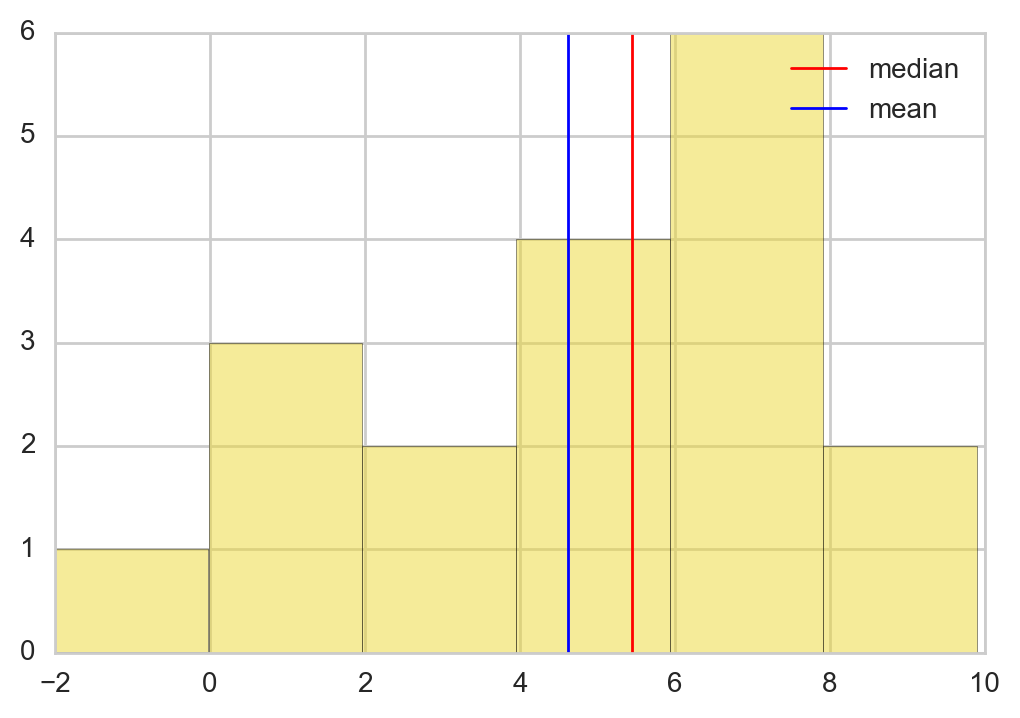

In [7]:
#Let's set the missing value to Nan and look at distribution of values in this column:

data.replace('-',np.NaN, inplace=True)
s = data.Growth_in_GVA_Bath
s = s.dropna()
plt.hist(s,
         bins=6,
         alpha=0.5,
         color='#EDD834')
plt.axvline(data.Growth_in_GVA_Bath.median(), color='r', linestyle='solid', linewidth=1, label = 'median')
plt.axvline(data.Growth_in_GVA_Bath.mean(), color='b', linestyle='solid', linewidth=1, label = 'mean')
plt.legend()
plt.show()

In [8]:
#Median and mean seem quite close. Our sample size is small and we have just one missing value, 
#so we will replace it with the mean; 
#model-based imputaton seems a bit of overkill in this case.

data.Growth_in_GVA_Bath = data.Growth_in_GVA_Bath.fillna(data.Growth_in_GVA_Bath.mean())

#### Statistical analysis and visualization

In [9]:
# Examining basic statistics:
data.describe()

,GVA_Bath,Growth_in_GVA_Bath,CoE_Bath,Mix_Inc_Bath,Rent_Inc_Bath,Cap_Con_Bath,Hold_Gains_Bath,GTP_Bath,GTS_Bath,Tax_Bath,Subs_Bath
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,13173.894737,4.627778,7413.473684,711.315789,1826.789474,347.315789,-30.894737,2721.473684,31.473684,201.842105,-29.736842
std,3173.707487,3.059740,1861.927954,116.358666,303.301936,99.671713,19.436205,841.099107,10.259784,49.233303,18.214287
min,7985.000000,-2.000000,4128.000000,459.000000,1225.000000,209.000000,-73.000000,1642.000000,19.000000,121.000000,-49.000000
25%,10544.500000,2.350000,5921.000000,636.500000,1659.500000,260.500000,-46.500000,1930.500000,25.000000,168.000000,-46.000000
50%,13519.000000,5.000000,7928.000000,725.000000,1860.000000,354.000000,-25.000000,2573.000000,28.000000,198.000000,-39.000000
75%,15729.000000,6.350000,9006.500000,772.000000,2031.000000,435.000000,-15.000000,3345.000000,38.500000,247.000000,-10.500000
max,17923.000000,9.900000,9819.000000,895.000000,2333.000000,487.000000,-6.000000,4281.000000,53.000000,280.000000,-6.000000


In the above table we can see that the columns we have in the dataset differ very signifiantly when it comes to the magnitude of numbers. As I intend to run linear regression, for better interpretability of the results and also to make visualization easier, I'm going to standardize the numbers.

In [10]:
#standarization
standard = StandardScaler()
standard.fit(data)
stand_data = pd.DataFrame(standard.transform(data),columns=data.columns)
stand_data.index = data.index
stand_data.head()

,GVA_Bath,Growth_in_GVA_Bath,CoE_Bath,Mix_Inc_Bath,Rent_Inc_Bath,Cap_Con_Bath,Hold_Gains_Bath,GTP_Bath,GTS_Bath,Tax_Bath,Subs_Bath
1997,-1.679765,0.000000,-1.812908,-2.227852,-2.038496,-1.374201,1.157361,-1.084049,-1.148961,-1.687016,1.282503
1998,-1.506249,0.695813,-1.631919,-1.291912,-1.632009,-1.425740,1.315942,-1.120694,-1.249100,-1.436600,1.226097
1999,-1.442476,-0.781623,-1.485141,-1.115320,-1.391505,-1.353585,0.787339,-1.318577,-0.948683,-1.311391,1.338910
2000,-1.250184,0.729391,-1.279322,-0.638521,-0.974856,-1.250507,0.311597,-1.286818,-0.447989,-0.977503,1.338910
2001,-0.956568,1.703156,-0.912378,-0.956387,-0.663216,-0.961886,0.417318,-1.130466,-0.648267,-0.789690,1.169691


#### Plotting the features

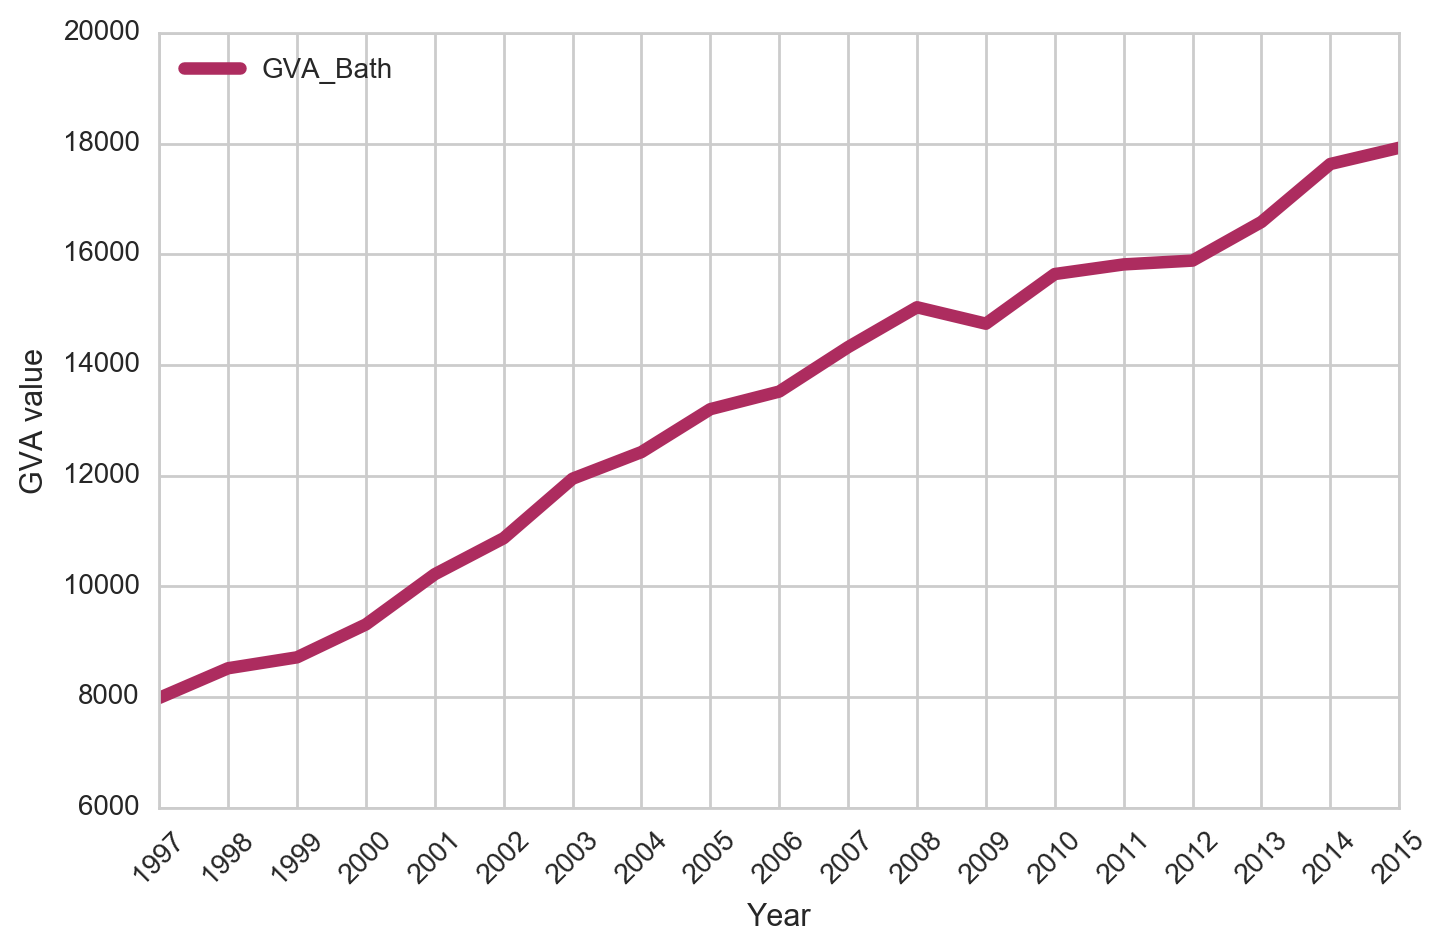

In [13]:
#Plotting the target feature - GVA_Bath (non-standardized values)

cols = data.columns.tolist()
plt.figure(figsize = (8, 5))
plt.plot(data.index, data.GVA_Bath, lw =4.5, c='#AD2C5F')
plt.xlim(1997,2015)
plt.ylim(6000, 20000)
plt.xticks(data.index.tolist(), rotation=45)
plt.legend(cols, loc='upper left')
plt.ylabel("GVA value")
plt.xlabel("Year")
plt.show()

The plot shows how GVA changed historically in the Bath area. We can see a steady growth over the years with just one significant dip from 2008 to 2009, probably due to the financial crisis of the late nougthies.

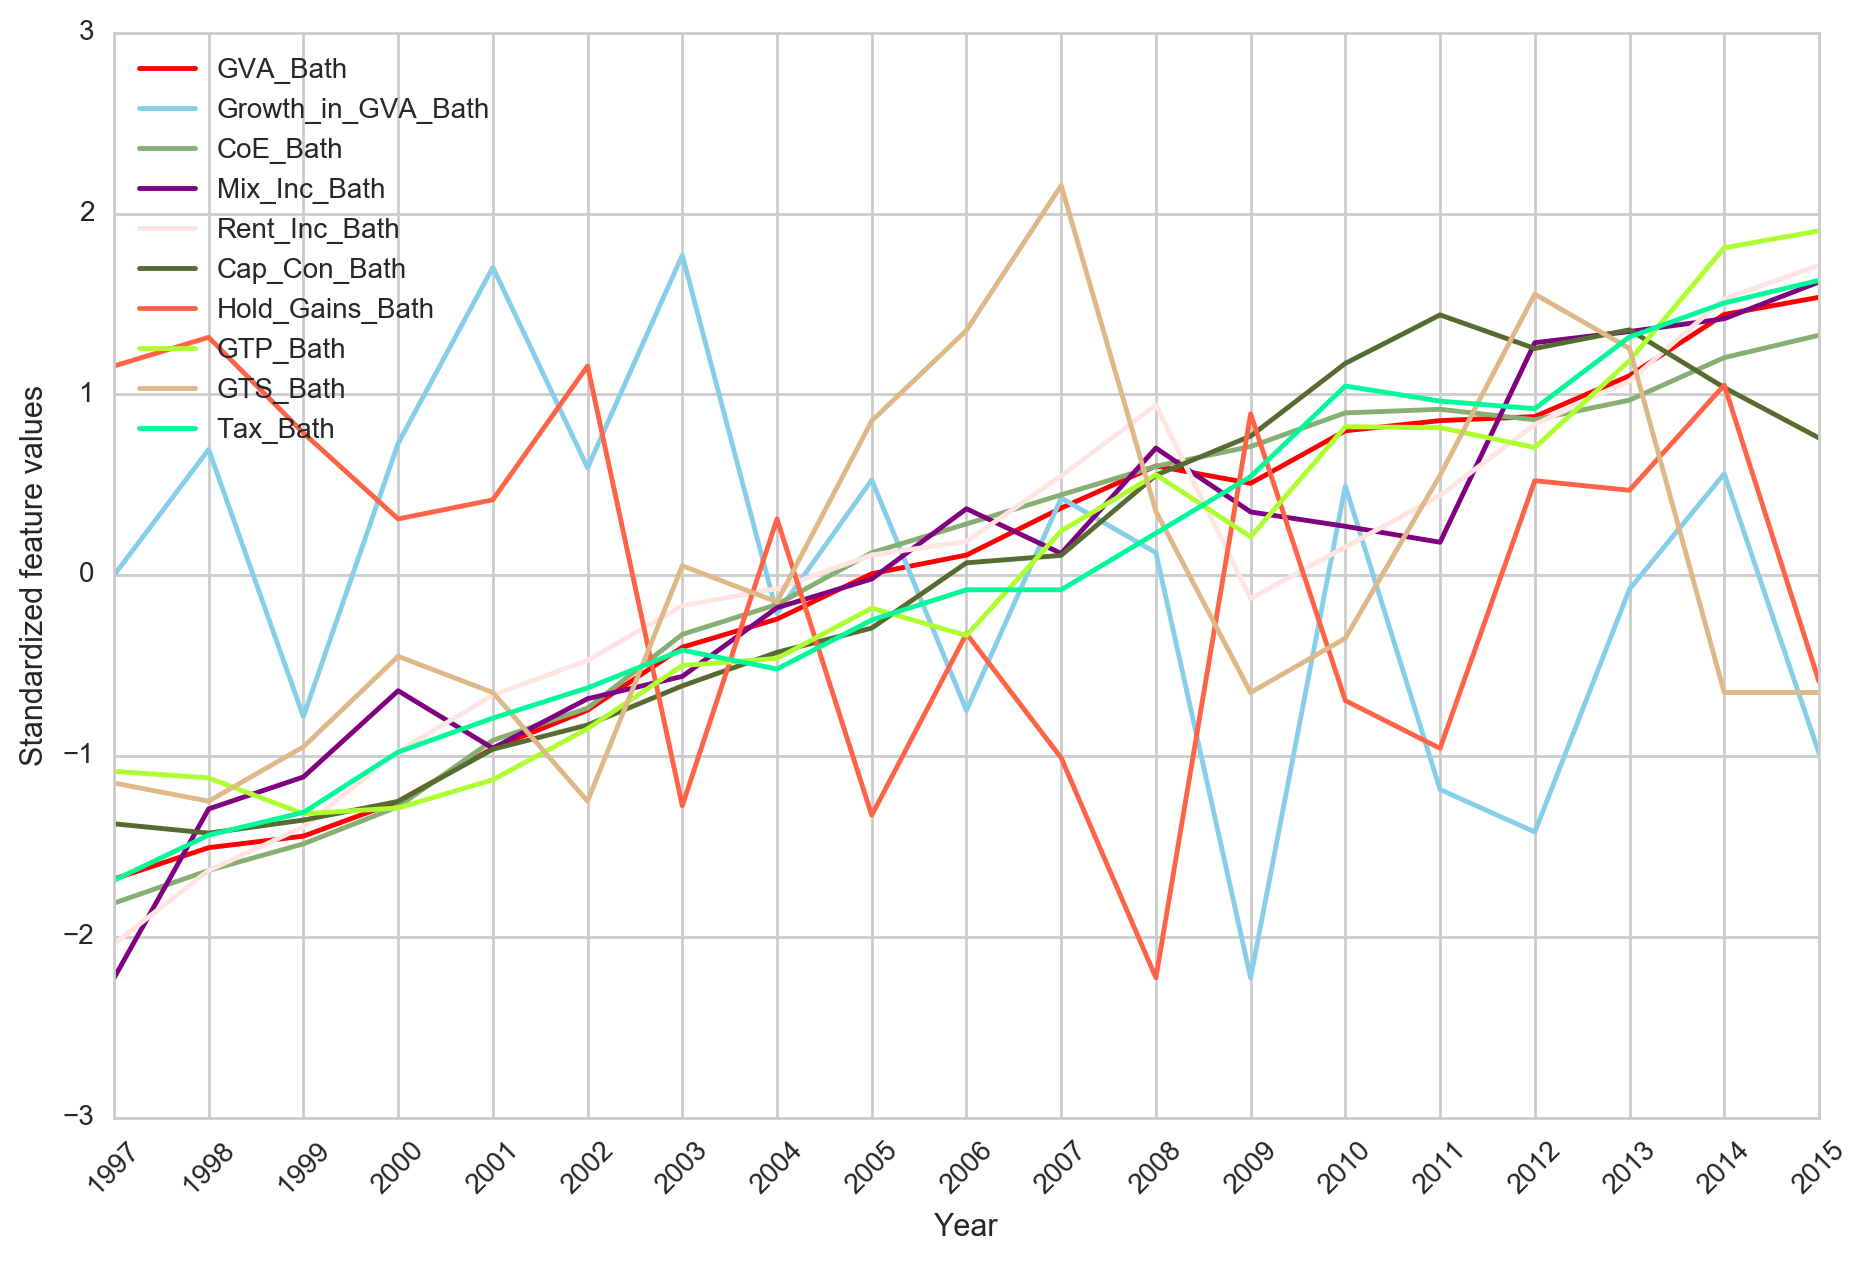

In [14]:
#Plotting all features (standardized)
cols = stand_data.columns.tolist()
colours = ['red','skyblue', 'sage', 'purple', 'mistyrose', 'darkolivegreen',
            'tomato', 'greenyellow', 'burlywood', 'mediumspringgreen']

plt.figure(figsize = (11, 7))
#plt.plot(stand_data.index, stand_data.GVA_Bath, lw =4.5, c='#AD2C5F')
for column, colour in zip(cols, colours):
    plt.plot(stand_data.index, stand_data[column], c= colour)

plt.xlim(1997,2015)
plt.xticks(stand_data.index.tolist(), rotation=45)
plt.legend(cols, loc='upper left')
plt.ylabel("Standardized feature values")
plt.xlabel("Year")
plt.show()

From the above chart we can see that while some features (Tax, CoE, Rent_Inc etc.) seem to follow similar steady growth trend as GVA (and as such they could be considered potentially good predictors for GVA levels), while other features (Growth, Hold_Gains, GTS) seem to be far more varied with lot of ups and downs over the years.

In [20]:
# Calculating p_values:
p_values = f_regression(stand_data[cols[1:]], stand_data.GVA_Bath)[1]
p_vals=["{0:.7f}".format(x)for x in p_values] 

for f, p in zip (cols[1:], p_vals):
    print f, p

Growth_in_GVA_Bath 0.1103963
CoE_Bath 0.0000000
Mix_Inc_Bath 0.0000000
Rent_Inc_Bath 0.0000000
Cap_Con_Bath 0.0000000
Hold_Gains_Bath 0.1004553
GTP_Bath 0.0000000
GTS_Bath 0.0365233
Tax_Bath 0.0000000
Subs_Bath 0.0000000


P-values obtained for our features suggest that the changes in variables with more erratic diagrams, as above mentioned Growth, Hold_Gains, and in lesser degree GTS, are not associated with changes in the target. Nevertheless I'm going to keep them as I don't believe significance alone is enough reason to remove them at this stage and the p-values obtained could be misleading due to the small sample size.

To see how well the features correlate let's build a heatmap:

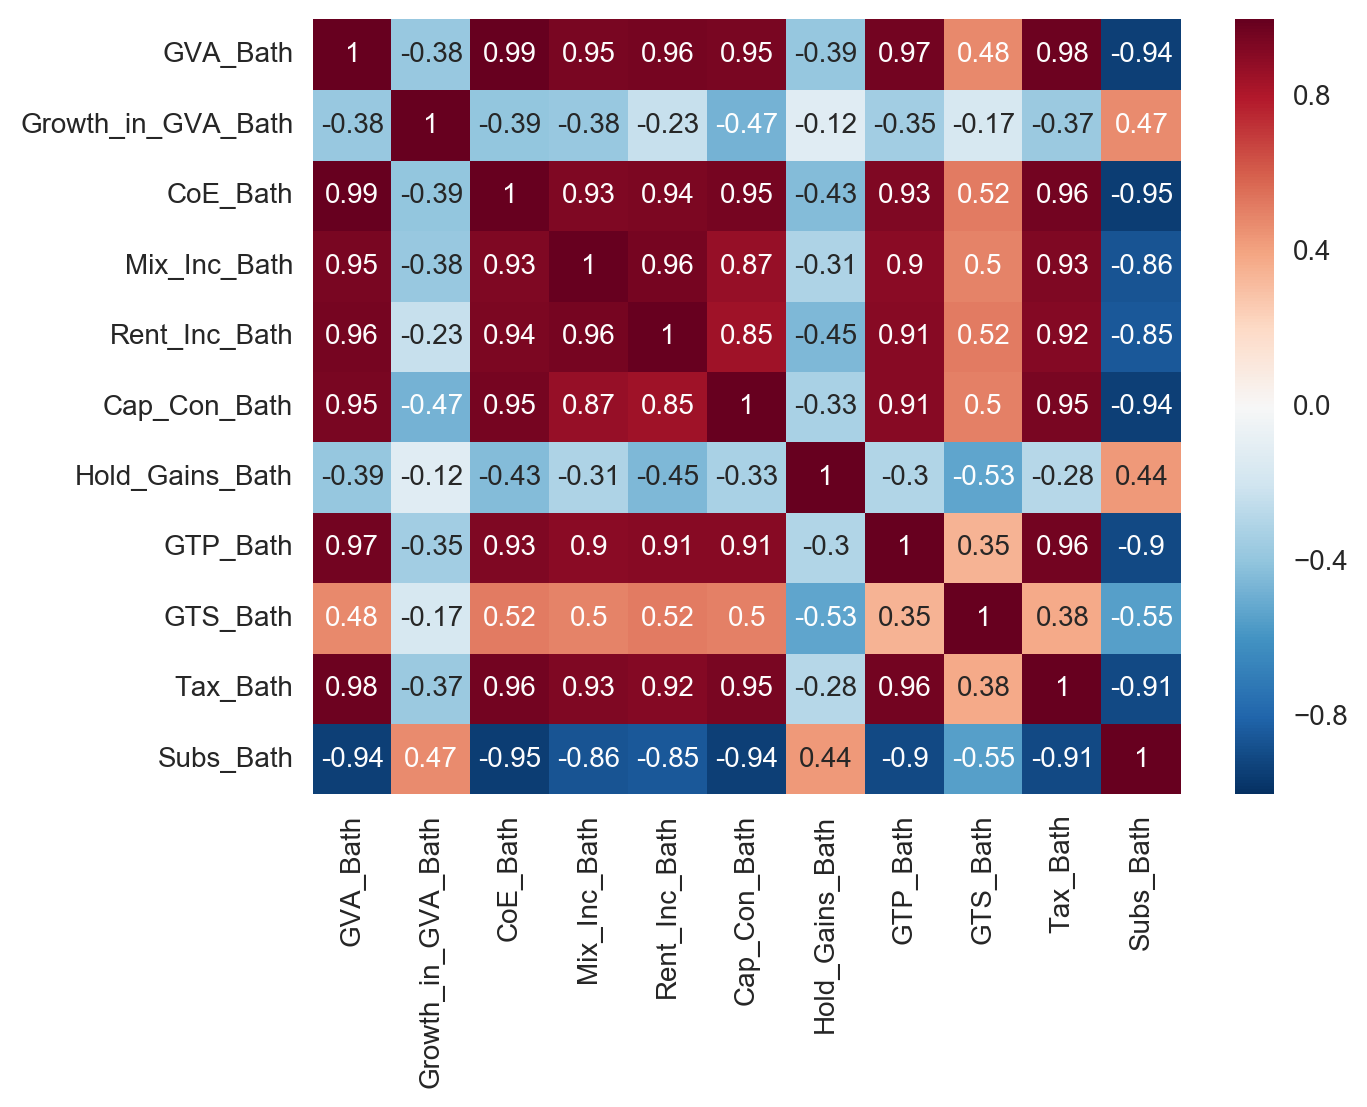

In [21]:
plt.figure(figsize = (7, 5))
sns.heatmap(stand_data.ix[:,'GVA_Bath':].corr(), annot = stand_data.ix[:,'GVA_Bath':].corr())
plt.show()

These are some very high correlation coefficients. I presumed the variables I'm using are exogenous in a sense that they are not derived from each other but perhaps it's not the case. CoE and Tax seem to be particularly well correlated with other features and the target but I would need more time to explore the underlying correlational structure of the data properly. For now I'm going to leave them as they are, bearing in mind that I might need to remedy this problem at a later stage.

Next, let's look at the pairplot:

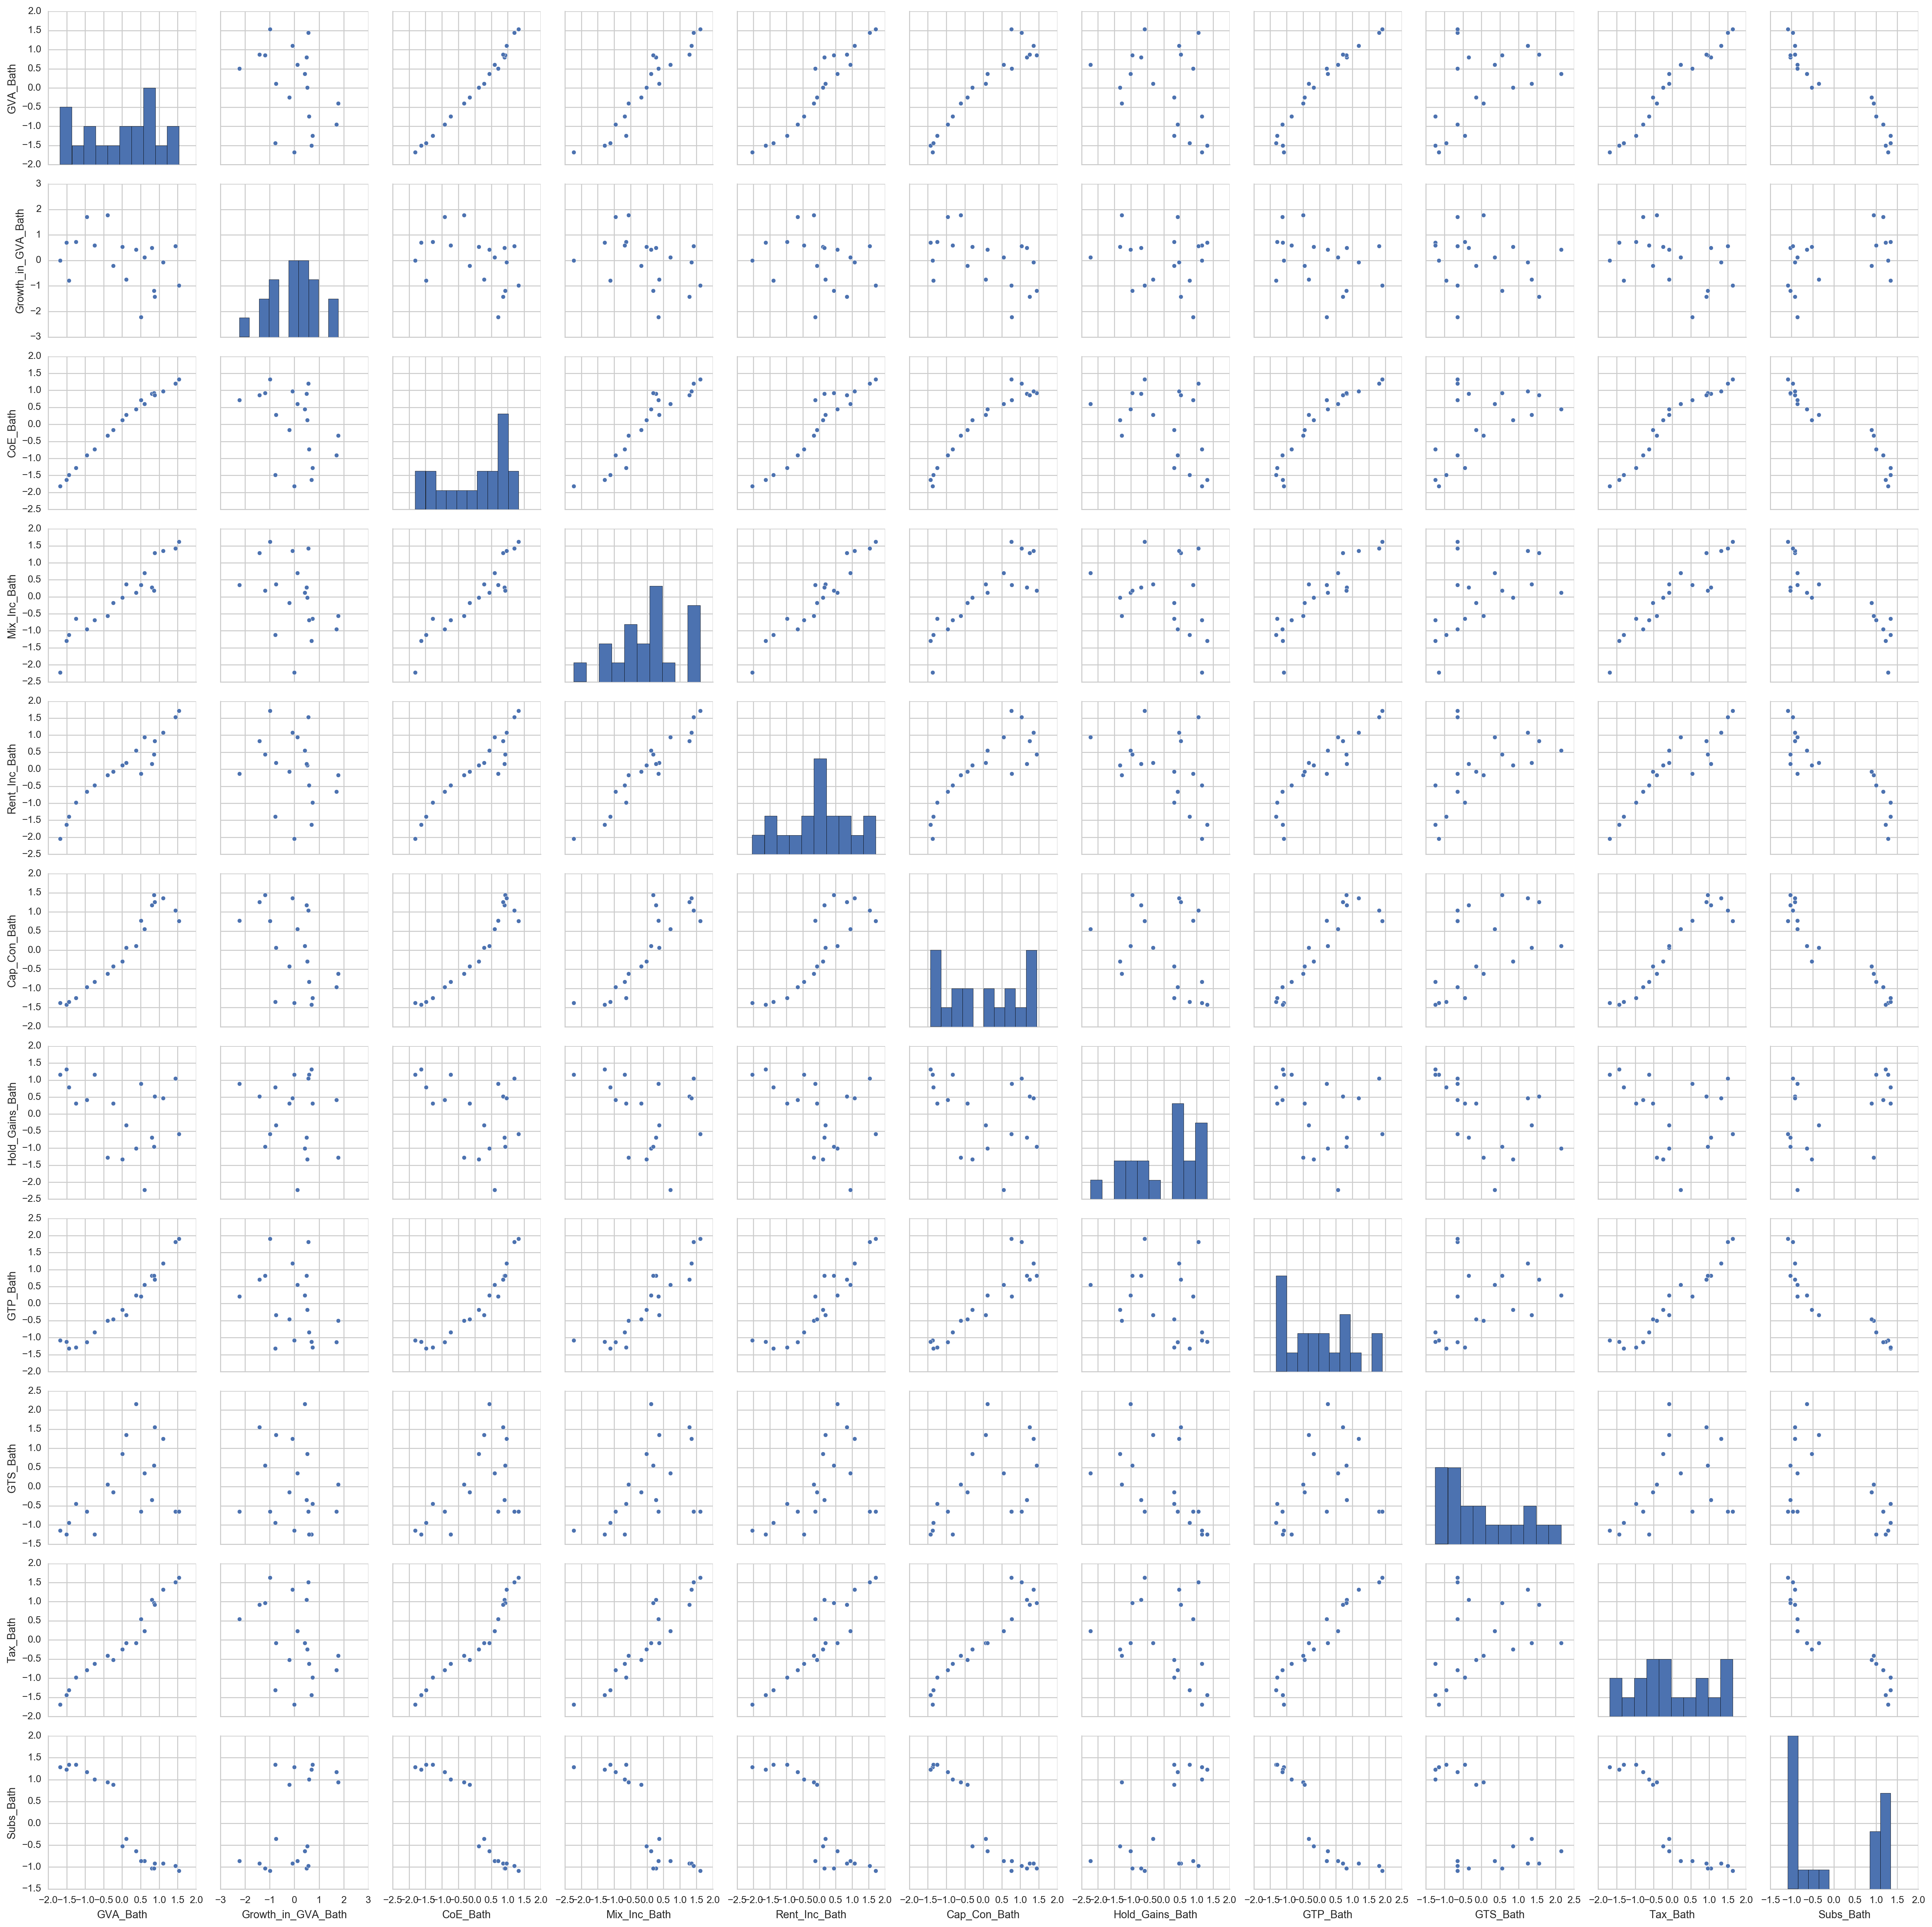

In [22]:
sns.pairplot(stand_data)
plt.show()

Indeed, some features have very strong linear relationship, especially CoE & Tax so we will need to consider removing them from the set or reengineering them if we would like to use the model not only for predicitons, but also for explaning which features influence the target the most. 

### 3. MODELLING

Normally the best practice would be to divide the dataset into train and test sets and validate model's quality by training it on the train set and testing it on a test set. Our dataset however has less than 20 observations therefore splitting it into train and test sets would result in a very small number of obserations in both sets. I'm going to use k-fold cross-validation instead and while I know that the best practice is to set aside a test set even when using cross-validation, I'm going to skip this step due to minimal amount of data.

#### Linear Regression

In [23]:
#Setting the target and feature matrix

st_data_cols = stand_data.columns

y= stand_data.GVA_Bath

X = stand_data[st_data_cols[1:]]

print X.shape, y.shape

(19, 10) (19,)


In [24]:
lm = LinearRegression()

lm.fit(X, y)

# Perform 10-fold cross validation
scores = cross_val_score(lm, X, y, cv=10)
print "Cross-validated R2 scores:", scores
print "Mean of cross-validated R2 scores:", scores.mean()

Cross-validated R2 scores: [ 0.99441507  0.99869962  0.99321464  0.928581    0.98013386  0.9924468
  0.98495394  0.48759984  0.99911418  0.        ]
Mean of cross-validated R2 scores: 0.835915893903


In [25]:
#Let's look at the coefficients:

featurenames = X.columns

for f, c in zip(featurenames, lm.coef_):
    print f, c

Growth_in_GVA_Bath -0.00161913280083
CoE_Bath 0.573331572787
Mix_Inc_Bath 0.027576884136
Rent_Inc_Bath 0.110212508772
Cap_Con_Bath 0.0340313573981
Hold_Gains_Bath 0.0126550258686
GTP_Bath 0.254335043408
GTS_Bath 0.00376131170898
Tax_Bath 0.0268486971245
Subs_Bath 0.0029199732314


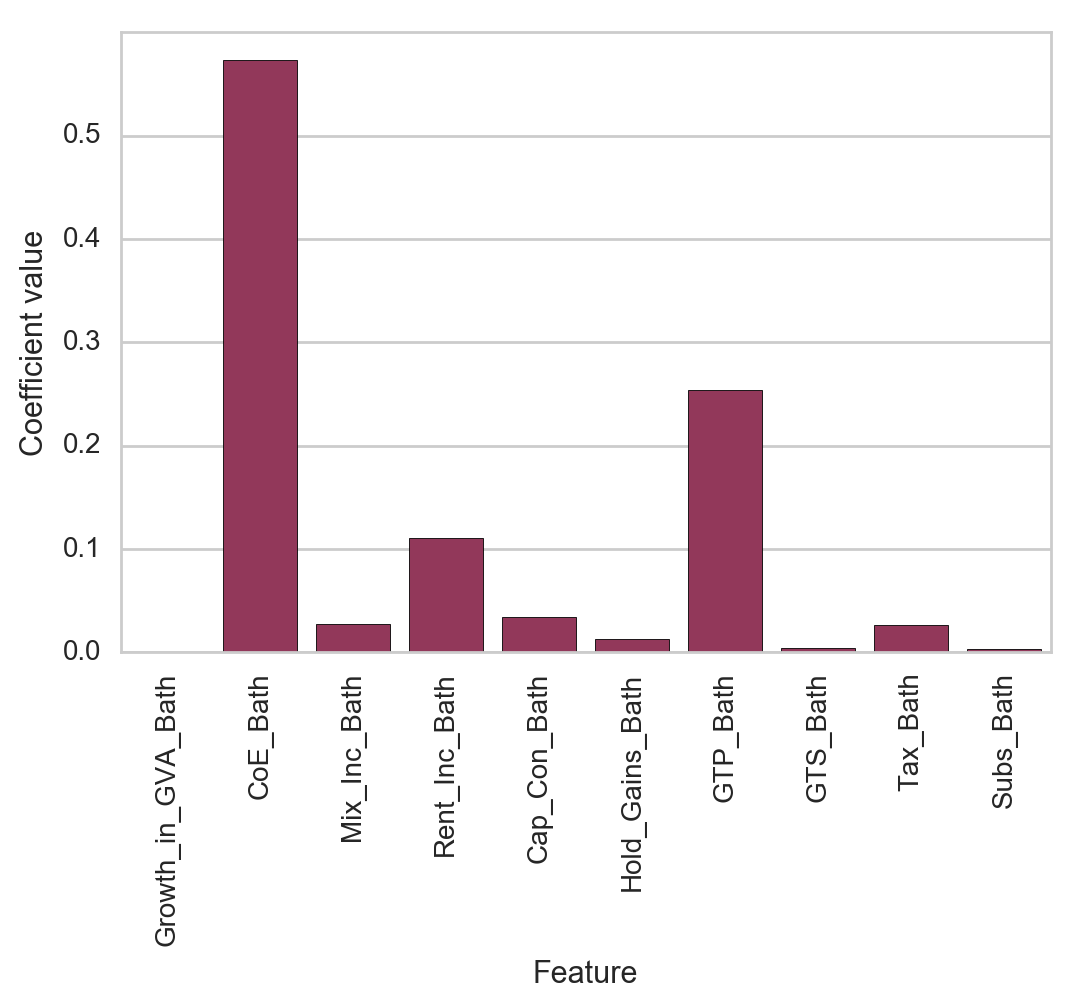

In [26]:
sns.barplot(featurenames, lm.coef_, ci=95, orient=None, 
            color='#a12957', palette=None, saturation=0.75)
plt.xticks(rotation=90)
plt.ylabel("Coefficient value")
plt.xlabel("Feature")
plt.ylim(0,.6)
plt.show()

#### Lasso

In [33]:
#Create a dictionary with the gridsearch parameters
params = {'alpha': np.logspace(-10,10,100)}

#Create and Fit a Lasso Regression Model, Testing Each Alpha

grid_lasso = GridSearchCV(Lasso(), params, cv=10)
grid_lasso.fit(X,y)

#Summarize the Results of the Grid Search
print "Best score:\n", grid_lasso.best_score_
print "Best estimator alpha: \n", grid_lasso.best_estimator_.alpha

Best score:
0.873672147186
Best estimator alpha: 
0.00018307382803


In [28]:
for f, c in zip(featurenames, grid_lasso.best_estimator_.coef_):
    print f, c

Growth_in_GVA_Bath -0.00109051727863
CoE_Bath 0.573419238063
Mix_Inc_Bath 0.0288023746914
Rent_Inc_Bath 0.109708481689
Cap_Con_Bath 0.0328613700727
Hold_Gains_Bath 0.0125541435231
GTP_Bath 0.252084236661
GTS_Bath 0.00289754232649
Tax_Bath 0.0270310647605
Subs_Bath -0.0


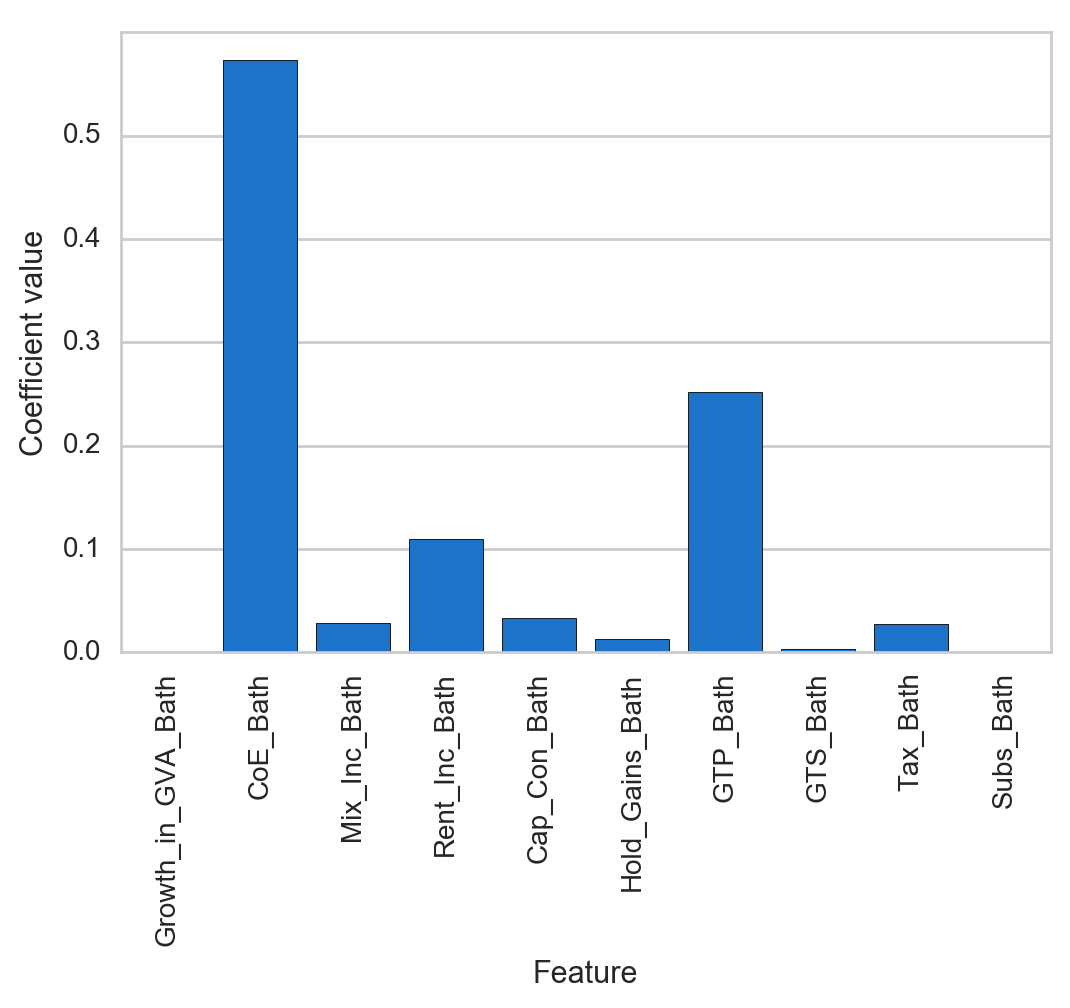

In [29]:
sns.barplot(featurenames, grid_lasso.best_estimator_.coef_, ci=95, orient=None, 
            color='#0073e6', palette=None, saturation=0.75)
plt.xticks(rotation=90)
plt.ylabel("Coefficient value")
plt.xlabel("Feature")
plt.ylim(0,.6)
plt.show()

Lasso ended up supressing Subs feature, the rest of coefficients look similar. Its best score is higher than the regular linear regression's score.

#### Ridge

In [30]:
#Create a dictionary with the gridsearch parameters
params = {'alpha': np.logspace(-10,10,100)}

#Create and Fit a Ridge Regression Model, Testing Each Alpha

grid_ridge = GridSearchCV(Ridge(), params, cv=10)
grid_ridge.fit(X,y)

#Summarize the Results of the Grid Search
print "Best score:\n", grid_ridge.best_score_
print "Best estimator alpha: \n", grid_ridge.best_estimator_.alpha

Best score:
0.880004613913
Best estimator alpha: 
0.00018307382803


In [31]:
for f, c in zip(featurenames, grid_ridge.best_estimator_.coef_):
    print f, c

Growth_in_GVA_Bath -0.00163854568438
CoE_Bath 0.57292497764
Mix_Inc_Bath 0.0274738703442
Rent_Inc_Bath 0.110461021648
Cap_Con_Bath 0.0340884354682
Hold_Gains_Bath 0.0126490249694
GTP_Bath 0.254178037288
GTS_Bath 0.00375196965031
Tax_Bath 0.0270646953758
Subs_Bath 0.00277074301445


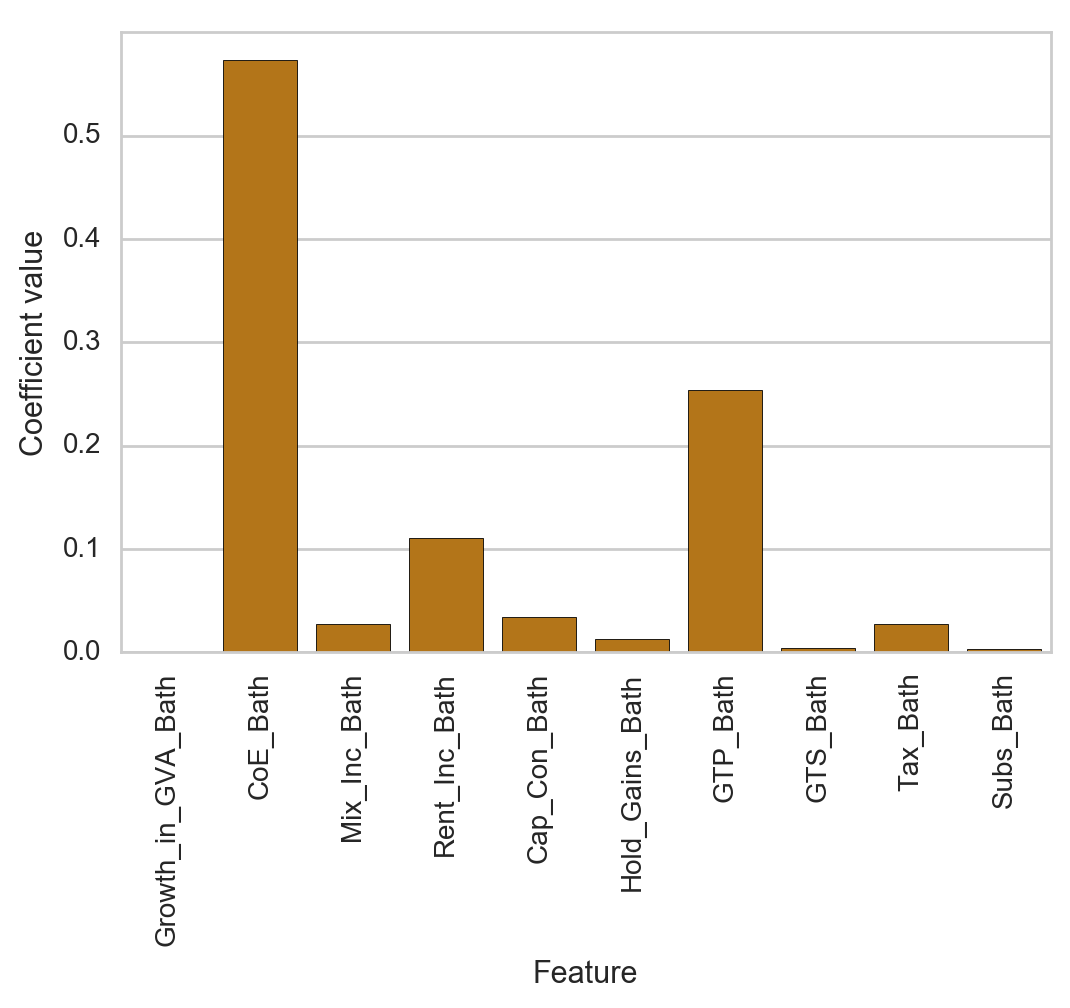

In [32]:
sns.barplot(featurenames, grid_ridge.best_estimator_.coef_, ci=95, orient=None, 
            color='#cc7a00', palette=None, saturation=0.75)
plt.xticks(rotation=90)
plt.ylabel("Coefficient value")
plt.xlabel("Feature")
plt.ylim(0,.6)
plt.show()

Ridge's results are very similar to regular linear regression.

### 4. SUMMARY

Having performed quick analysis we can confirm that there is a clear growth trend in GVA in Bath area in years 1997 - 2016. 

All three models worked well as far as we can say without testing them, with somewhat similar R2 scores from .83 in case of logistic regression to .88 in case of Ridge. For all models, considering all other variables fixed, CoE os the feature which has the biggest impact on GVA.